# ECG Preprocessing Results Analysis

This notebook analyzes the results from the ECG preprocessing pipeline on the SeizeIT2 dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Preprocessed Data

In [2]:
# Load preprocessed results
results_path = Path("/home/swolf/asim_shared/preprocessed_data/downsample_freq=8,window_size=3600_0,stride=1800_0")

# Find all preprocessed files
preprocessed_files = list(results_path.glob("*.pkl"))
print(f"Found {len(preprocessed_files)} preprocessed files:")
for file in preprocessed_files:
    print(f"  - {file.name}")

# Load all results
all_results = []
for file in preprocessed_files:
    with open(file, 'rb') as f:
        result = pickle.load(f)
        all_results.append(result)

print(f"\nLoaded {len(all_results)} recordings")

Found 2795 preprocessed files:
  - sub-092_run-16_preprocessed.pkl
  - sub-073_run-19_preprocessed.pkl
  - sub-092_run-84_preprocessed.pkl
  - sub-119_run-24_preprocessed.pkl
  - sub-008_run-02_preprocessed.pkl
  - sub-074_run-06_preprocessed.pkl
  - sub-039_run-04_preprocessed.pkl
  - sub-087_run-01_preprocessed.pkl
  - sub-080_run-30_preprocessed.pkl
  - sub-092_run-40_preprocessed.pkl
  - sub-080_run-27_preprocessed.pkl
  - sub-083_run-36_preprocessed.pkl
  - sub-095_run-53_preprocessed.pkl
  - sub-123_run-79_preprocessed.pkl
  - sub-115_run-66_preprocessed.pkl
  - sub-095_run-86_preprocessed.pkl
  - sub-089_run-04_preprocessed.pkl
  - sub-030_run-07_preprocessed.pkl
  - sub-123_run-84_preprocessed.pkl
  - sub-084_run-25_preprocessed.pkl
  - sub-070_run-19_preprocessed.pkl
  - sub-074_run-13_preprocessed.pkl
  - sub-115_run-60_preprocessed.pkl
  - sub-124_run-32_preprocessed.pkl
  - sub-002_run-01_preprocessed.pkl
  - sub-124_run-34_preprocessed.pkl
  - sub-088_run-03_preprocessed.p

## 2. Data Overview

In [3]:
# Create summary dataframe
summary_data = []

for result in all_results:
    for channel in result['channels']:
        summary_data.append({
            'subject_id': result['subject_id'],
            'run_id': result['run_id'],
            'channel_name': channel['channel_name'],
            'recording_duration': result['recording_duration'],
            'original_fs': channel['original_fs'],
            'processed_fs': channel['processed_fs'],
            'n_windows': channel['n_windows'],
            'n_seizure_windows': channel['n_seizure_windows'],
            'total_seizures': result['total_seizures']
        })

summary_df = pd.DataFrame(summary_data)
print("Summary of preprocessed data:")
print(summary_df)

Summary of preprocessed data:
     subject_id  run_id channel_name  recording_duration  original_fs  \
0       sub-092  run-16       ECG SD              3534.0          256   
1       sub-073  run-19       ECG SD             21548.0          256   
2       sub-092  run-84       ECG SD              3563.0          256   
3       sub-119  run-24       ECG SD              8842.0          256   
4       sub-008  run-02       ECG SD             61400.0          256   
...         ...     ...          ...                 ...          ...   
2790    sub-123  run-73       ECG SD              3546.0          256   
2791    sub-093  run-99       ECG SD              1627.0          256   
2792    sub-085  run-41       ECG SD              3440.0          256   
2793    sub-121  run-44       ECG SD              2311.0          256   
2794    sub-094  run-29       ECG SD              3560.0          256   

      processed_fs  n_windows  n_seizure_windows  total_seizures  
0                8        

## 3. Preprocessing Statistics

In [4]:
# Calculate key statistics
total_duration = summary_df['recording_duration'].sum() / 3600  # hours
total_windows = summary_df['n_windows'].sum()
total_seizure_windows = summary_df['n_seizure_windows'].sum()
seizure_percentage = (total_seizure_windows / total_windows) * 100

print("📊 PREPROCESSING STATISTICS")
print("=" * 40)
print(f"Total recordings:        {len(all_results)}")
print(f"Total duration:          {total_duration:.1f} hours")
print(f"Total windows:           {total_windows:,}")
print(f"Seizure windows:         {total_seizure_windows:,}")
print(f"Seizure percentage:      {seizure_percentage:.2f}%")
print(f"Window size:             3600 seconds")
print(f"Window overlap:          50% (1800s stride)")
print(f"Sampling rate:           250 Hz → 8 Hz")

📊 PREPROCESSING STATISTICS
Total recordings:        2795
Total duration:          11244.5 hours
Total windows:           17,774
Seizure windows:         887
Seizure percentage:      4.99%
Window size:             3600 seconds
Window overlap:          50% (1800s stride)
Sampling rate:           250 Hz → 8 Hz


## 4. Signal Visualization

In [5]:
# Get first recording for visualization
first_result = all_results[0]
first_channel = first_result['channels'][0]

# Extract first few windows
n_windows_to_plot = min(4, len(first_channel['windows']))
sample_windows = first_channel['windows'][:n_windows_to_plot]
sample_labels = first_channel['labels'][:n_windows_to_plot]
sample_metadata = first_channel['metadata'][:n_windows_to_plot]

# Create time axis (30 seconds at 125 Hz)
fs = first_channel['processed_fs']
time_axis = np.arange(len(sample_windows[0])) / fs

# Plot sample windows
fig, axes = plt.subplots(n_windows_to_plot, 1, figsize=(15, 3*n_windows_to_plot))
if n_windows_to_plot == 1:
    axes = [axes]

for i, (window, label, meta) in enumerate(zip(sample_windows, sample_labels, sample_metadata)):
    color = 'red' if label == 1 else 'blue'
    label_text = 'Seizure' if label == 1 else 'Normal'
    
    axes[i].plot(time_axis, window, color=color, linewidth=0.8)
    axes[i].set_title(f'Window {i+1}: {label_text} (Start: {meta["start_time"]:.1f}s)', 
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Time (seconds)')
    axes[i].set_ylabel('ECG Amplitude')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = np.mean(window)
    std_val = np.std(window)
    axes[i].text(0.02, 0.98, f'μ={mean_val:.3f}, σ={std_val:.3f}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle(f'Sample ECG Windows - {first_result["subject_id"]} {first_result["run_id"]}', 
             fontsize=16, y=1.02)
plt.show()

IndexError: list index out of range

## 5. Window Distribution Analysis

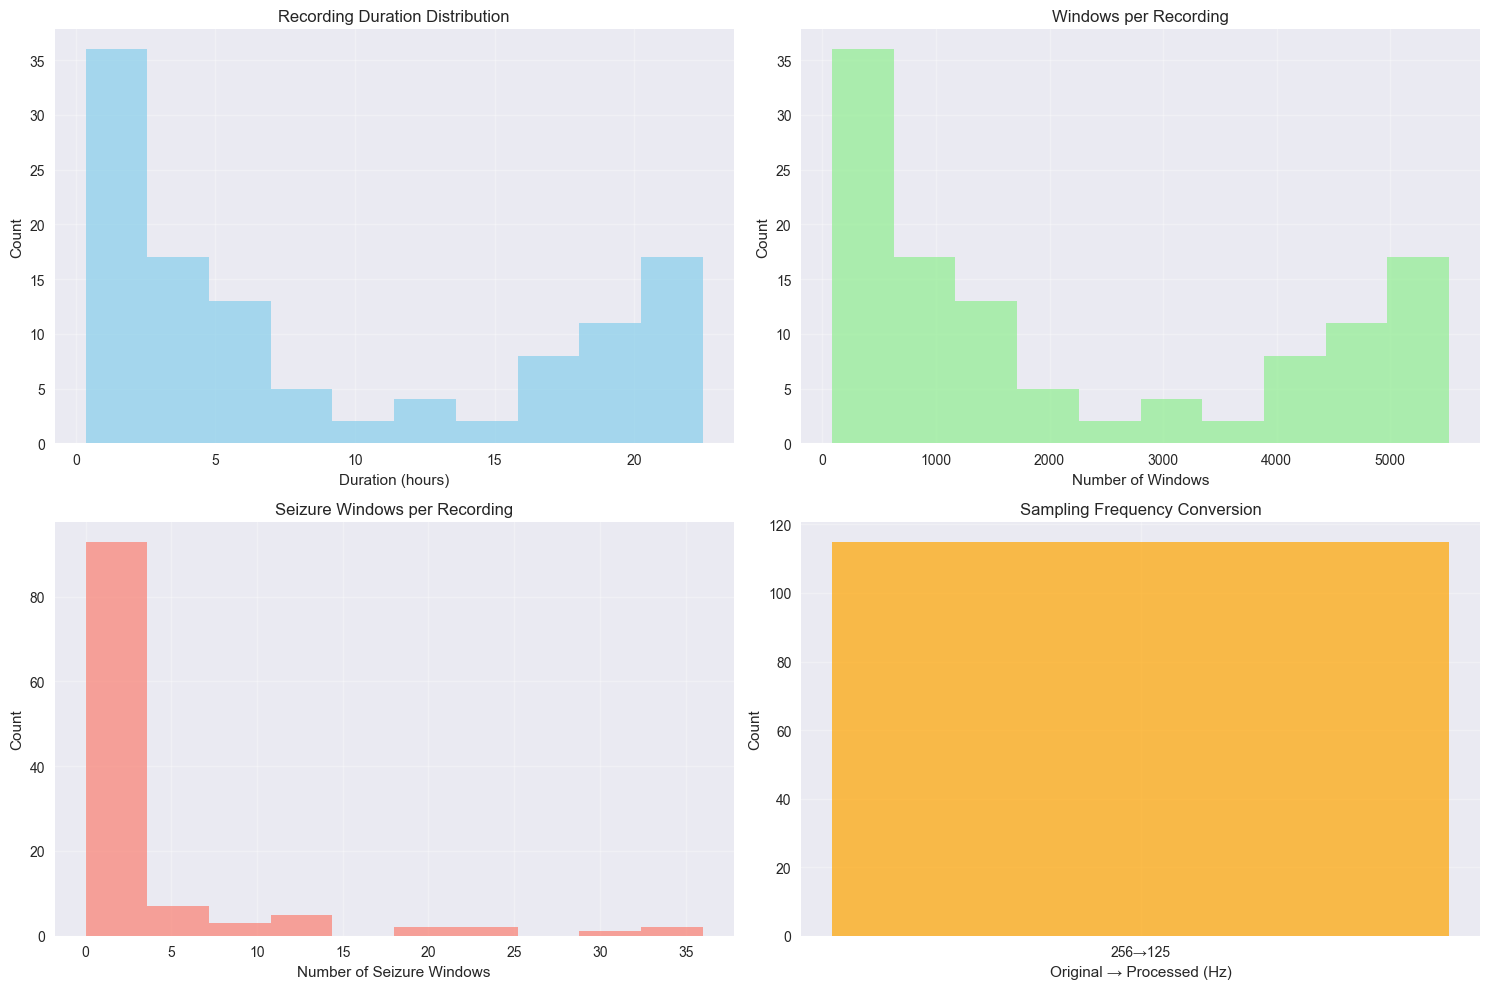

In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Recording duration distribution
axes[0,0].hist(summary_df['recording_duration']/3600, bins=10, alpha=0.7, color='skyblue')
axes[0,0].set_title('Recording Duration Distribution')
axes[0,0].set_xlabel('Duration (hours)')
axes[0,0].set_ylabel('Count')
axes[0,0].grid(True, alpha=0.3)

# 2. Number of windows per recording
axes[0,1].hist(summary_df['n_windows'], bins=10, alpha=0.7, color='lightgreen')
axes[0,1].set_title('Windows per Recording')
axes[0,1].set_xlabel('Number of Windows')
axes[0,1].set_ylabel('Count')
axes[0,1].grid(True, alpha=0.3)

# 3. Seizure windows distribution
axes[1,0].hist(summary_df['n_seizure_windows'], bins=10, alpha=0.7, color='salmon')
axes[1,0].set_title('Seizure Windows per Recording')
axes[1,0].set_xlabel('Number of Seizure Windows')
axes[1,0].set_ylabel('Count')
axes[1,0].grid(True, alpha=0.3)

# 4. Sampling frequency
freq_counts = summary_df.groupby(['original_fs', 'processed_fs']).size().reset_index(name='count')
axes[1,1].bar(range(len(freq_counts)), freq_counts['count'], 
             color='orange', alpha=0.7)
axes[1,1].set_title('Sampling Frequency Conversion')
axes[1,1].set_xlabel('Original → Processed (Hz)')
axes[1,1].set_ylabel('Count')
axes[1,1].set_xticks(range(len(freq_counts)))
axes[1,1].set_xticklabels([f'{row.original_fs}→{row.processed_fs}' 
                          for _, row in freq_counts.iterrows()])
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Signal Quality Assessment

In [ ]:
# Analyze signal characteristics across all windows
all_window_stats = []

for result in all_results:
    for channel in result['channels']:
        for i, (window, label) in enumerate(zip(channel['windows'], channel['labels'])):
            stats = {
                'subject_id': result['subject_id'],
                'run_id': result['run_id'],
                'window_idx': i,
                'label': label,
                'mean': np.mean(window),
                'std': np.std(window),
                'min': np.min(window),
                'max': np.max(window),
                'range': np.max(window) - np.min(window),
                'rms': np.sqrt(np.mean(window**2))
            }
            all_window_stats.append(stats)

stats_df = pd.DataFrame(all_window_stats)

# Sample first 1000 windows for visualization (performance)
sample_stats = stats_df.head(1000)

print(f"Signal statistics computed for {len(stats_df)} windows")
print(f"Showing sample of {len(sample_stats)} windows")
print("\nSignal Quality Overview:")
print(stats_df[['mean', 'std', 'min', 'max', 'range', 'rms']].describe())

Signal statistics computed for 256813 windows
Showing sample of 1000 windows

Signal Quality Overview:
                mean           std           min           max         range  \
count  256813.000000  2.568130e+05  2.568130e+05  2.568130e+05  2.568130e+05   
mean       -0.000032  5.285814e+01 -2.067329e+02  3.159039e+02  5.226368e+02   
std         0.352547  4.642578e+01  2.823562e+02  2.889750e+02  5.338614e+02   
min        -7.609217  3.522271e-13 -2.369593e+03  7.724953e-13  1.499661e-12   
25%        -0.081631  2.729908e+01 -2.054371e+02  1.232685e+02  2.264009e+02   
50%         0.000072  3.805412e+01 -1.240915e+02  2.187032e+02  3.422326e+02   
75%         0.080313  6.868428e+01 -7.166677e+01  4.288177e+02  6.388220e+02   
max         8.496983  5.692922e+02 -7.271658e-13  2.346787e+03  4.305355e+03   

                rms  
count  2.568130e+05  
mean   5.285873e+01  
std    4.642645e+01  
min    3.522271e-13  
25%    2.729923e+01  
50%    3.805428e+01  
75%    6.868643e+01  


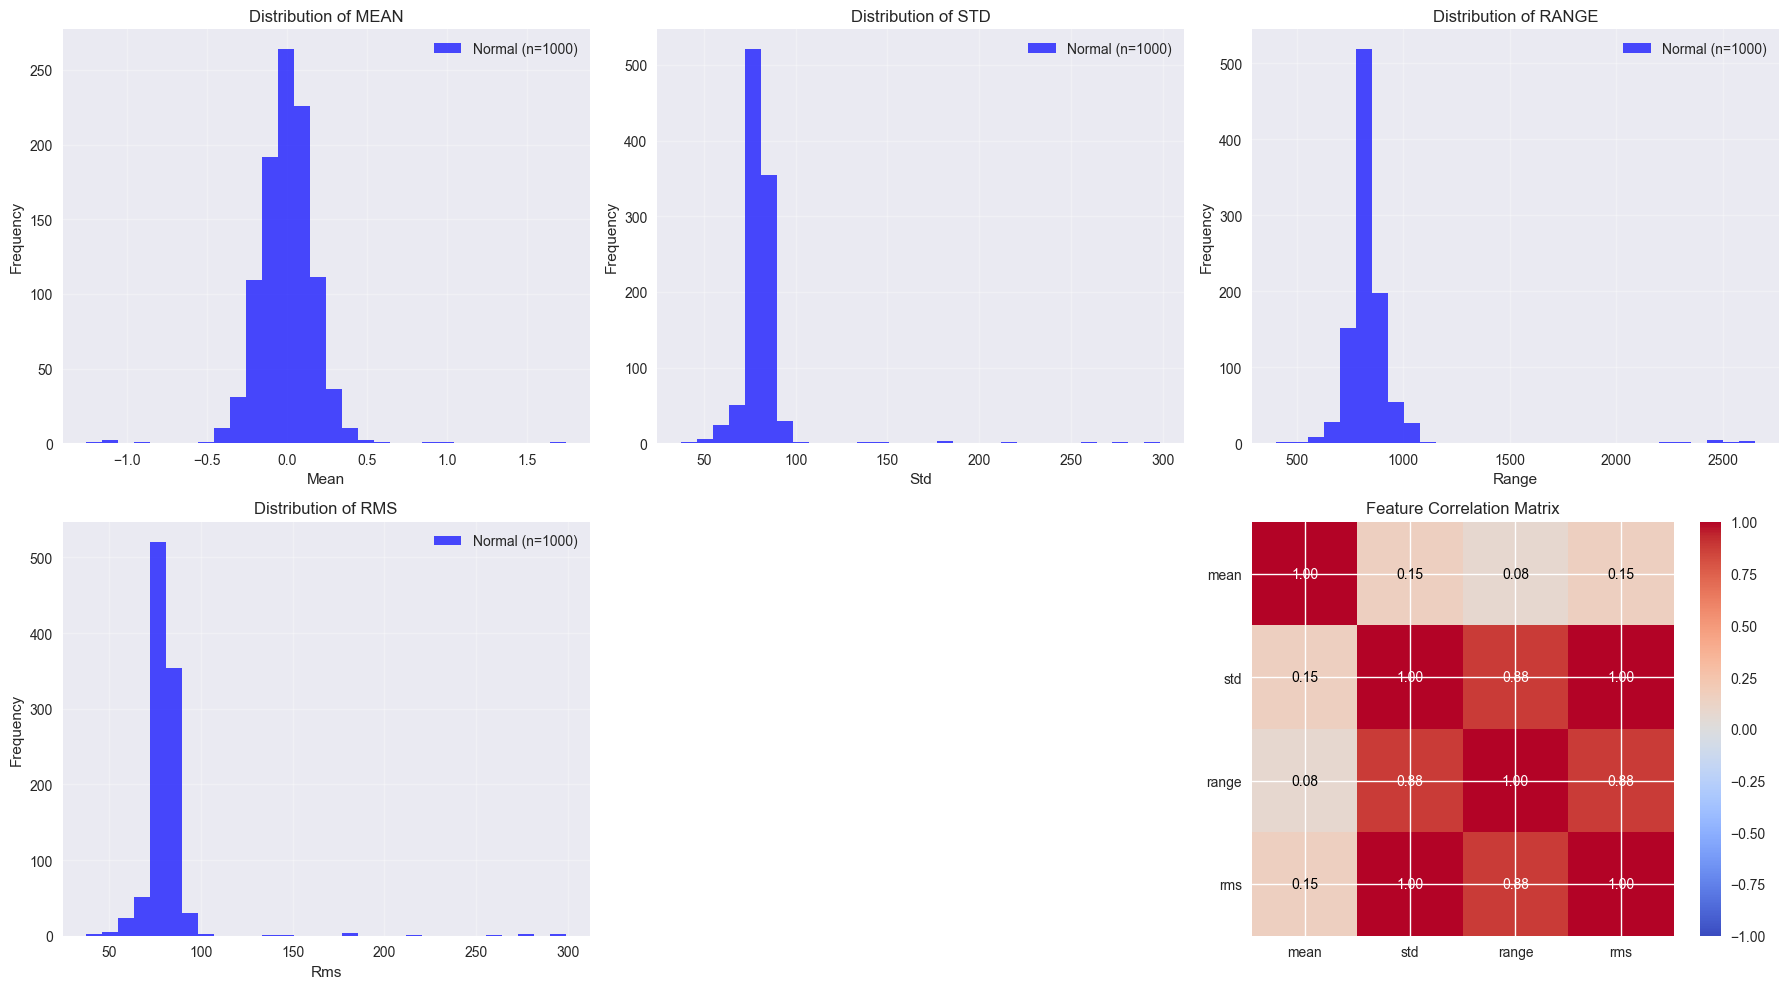

In [ ]:
# Signal quality visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot distributions for normal vs seizure windows (if any seizure windows exist)
normal_windows = sample_stats[sample_stats['label'] == 0]
seizure_windows = sample_stats[sample_stats['label'] == 1]

metrics = ['mean', 'std', 'range', 'rms']
colors = ['blue', 'red']
labels = ['Normal', 'Seizure']

for i, metric in enumerate(metrics):
    row, col = i // 3, i % 3
    
    # Plot histograms
    axes[row, col].hist(normal_windows[metric], alpha=0.7, color=colors[0], 
                       label=f'{labels[0]} (n={len(normal_windows)})', bins=30)
    
    if len(seizure_windows) > 0:
        axes[row, col].hist(seizure_windows[metric], alpha=0.7, color=colors[1], 
                           label=f'{labels[1]} (n={len(seizure_windows)})', bins=30)
    
    axes[row, col].set_title(f'Distribution of {metric.upper()}')
    axes[row, col].set_xlabel(metric.capitalize())
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

# Correlation matrix
correlation_data = sample_stats[['mean', 'std', 'range', 'rms']]
corr_matrix = correlation_data.corr()

im = axes[1, 2].imshow(corr_matrix, cmap='coolwarm', aspect='auto', 
                      vmin=-1, vmax=1)
axes[1, 2].set_title('Feature Correlation Matrix')
axes[1, 2].set_xticks(range(len(corr_matrix.columns)))
axes[1, 2].set_yticks(range(len(corr_matrix.columns)))
axes[1, 2].set_xticklabels(corr_matrix.columns)
axes[1, 2].set_yticklabels(corr_matrix.columns)

# Add correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        axes[1, 2].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                       ha='center', va='center', 
                       color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')

plt.colorbar(im, ax=axes[1, 2])

# Remove empty subplot
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

## 7. Preprocessing Summary

In [ ]:
# Create comprehensive summary
print("🎯 ECG PREPROCESSING PIPELINE SUMMARY")
print("=" * 50)

print("\n📁 DATA PROCESSING:")
print(f"  • Recordings processed:     {len(all_results)}")
print(f"  • Total duration:           {total_duration:.1f} hours")
print(f"  • Average recording length: {total_duration/len(all_results):.1f} hours")

print("\n⚙️ PREPROCESSING SETTINGS:")
preprocessing_params = all_results[0]['preprocessing_params']
print(f"  • Bandpass filter:          {preprocessing_params['filter_params']['low_freq']}-{preprocessing_params['filter_params']['high_freq']} Hz")
print(f"  • Filter order:             {preprocessing_params['filter_params']['order']}")
print(f"  • Downsampling:             250 Hz → {preprocessing_params['downsample_freq']} Hz")
print(f"  • Window size:              {preprocessing_params['window_size']} seconds")
print(f"  • Window stride:            {preprocessing_params['stride']} seconds ({preprocessing_params['stride']/preprocessing_params['window_size']*100:.0f}% overlap)")

print("\n📊 WINDOWING RESULTS:")
print(f"  • Total windows created:    {total_windows:,}")
print(f"  • Seizure windows:          {total_seizure_windows:,} ({seizure_percentage:.2f}%)")
print(f"  • Normal windows:           {total_windows - total_seizure_windows:,} ({100-seizure_percentage:.2f}%)")
print(f"  • Window shape:             ({len(sample_windows[0])},) samples")
print(f"  • Memory per window:        ~{len(sample_windows[0]) * 8 / 1024:.1f} KB")

print("\n🔍 SIGNAL CHARACTERISTICS:")
print(f"  • Mean amplitude:           {stats_df['mean'].mean():.4f} ± {stats_df['mean'].std():.4f}")
print(f"  • Signal variability (std): {stats_df['std'].mean():.4f} ± {stats_df['std'].std():.4f}")
print(f"  • Dynamic range:            {stats_df['range'].mean():.4f} ± {stats_df['range'].std():.4f}")
print(f"  • RMS value:                {stats_df['rms'].mean():.4f} ± {stats_df['rms'].std():.4f}")

print("\n💾 OUTPUT FILES:")
for file in preprocessed_files:
    size_mb = file.stat().st_size / (1024*1024)
    print(f"  • {file.name:<30} ({size_mb:.1f} MB)")

print("\n✅ STATUS: Preprocessing pipeline completed successfully!")
print("\n🚀 READY FOR: Anomaly detection model training")

🎯 ECG PREPROCESSING PIPELINE SUMMARY

📁 DATA PROCESSING:
  • Recordings processed:     115
  • Total duration:           1045.7 hours
  • Average recording length: 9.1 hours

⚙️ PREPROCESSING SETTINGS:
  • Bandpass filter:          0.5-40.0 Hz
  • Filter order:             4
  • Downsampling:             250 Hz → 125 Hz
  • Window size:              30.0 seconds
  • Window stride:            15.0 seconds (50% overlap)

📊 WINDOWING RESULTS:
  • Total windows created:    256,813
  • Seizure windows:          309 (0.12%)
  • Normal windows:           256,504 (99.88%)
  • Window shape:             (3750,) samples
  • Memory per window:        ~29.3 KB

🔍 SIGNAL CHARACTERISTICS:
  • Mean amplitude:           -0.0000 ± 0.3525
  • Signal variability (std): 52.8581 ± 46.4258
  • Dynamic range:            522.6368 ± 533.8614
  • RMS value:                52.8587 ± 46.4264

💾 OUTPUT FILES:
  • sub-001_run-01_preprocessed.pkl (128.0 MB)
  • sub-001_run-02_preprocessed.pkl (38.8 MB)
  • sub-001_ru